In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.model_selection import train_test_split

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['test.csv', 'train.csv', 'gender_submission.csv']


In [2]:


# Read the data
train= pd.read_csv('../input/train.csv')
train['Label'] = 'train'

test = pd.read_csv('../input/test.csv')
test['Label'] = 'test'

# Process as full dataset
train.dropna(axis=0, subset=['Survived'], inplace=True) # Drop rows with uknown survival
X_full = pd.concat([train.drop('Survived', axis = 1), test], axis = 0)
X_full.drop('PassengerId', axis = 1, inplace=True)

# Select categorical columns
print("Categorical features: ", [cname for cname in X_full.columns if X_full[cname].dtype == "object"])

# Select numeric columns
print("Numeric features: ", [cname for cname in X_full.columns if X_full[cname].dtype in ['int64', 'float64']])

X_full.head()


Categorical features:  ['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked', 'Label']
Numeric features:  ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']


,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Label
0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,train
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,train
2,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,train
3,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,train
4,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,train


In [3]:
missing_val_count_by_column = (X_full.isnull().sum())
print(missing_val_count_by_column[missing_val_count_by_column > 0])

Age          263
Fare           1
Cabin       1014
Embarked       2
dtype: int64


In [4]:
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Remove unuseful features
X_full.drop('Name', axis=1, inplace=True)
X_full.drop('Ticket', axis=1, inplace=True)
X_full.drop('Cabin', axis=1, inplace=True)

# Setup method for missing data using a median imputer for important numeric features
num_simple_imputer = SimpleImputer(strategy='median')
numeric_features = ['Age', 'Fare', 'Pclass', 'SibSp', 'Parch']
num_transformed = pd.DataFrame(num_simple_imputer.fit_transform(X_full[numeric_features]))
num_transformed.columns = numeric_features

# Setup one hot enoding for catagorical features
cat_simple_imputer = SimpleImputer(strategy='constant', fill_value='missing')
categorical_features = ['Embarked','Sex', 'Label']
cat_transformed = pd.DataFrame(cat_simple_imputer.fit_transform(X_full[categorical_features]))
cat_transformed.columns = categorical_features
X_dummies = pd.get_dummies(cat_transformed, columns = categorical_features)
X_full = pd.concat([num_transformed, X_dummies], axis = 1)

print(X_full.dtypes)
print(X_full.head())

Age                 float64
Fare                float64
Pclass              float64
SibSp               float64
Parch               float64
Embarked_C            uint8
Embarked_Q            uint8
Embarked_S            uint8
Embarked_missing      uint8
Sex_female            uint8
Sex_male              uint8
Label_test            uint8
Label_train           uint8
dtype: object
    Age     Fare  Pclass     ...       Sex_male  Label_test  Label_train
0  22.0   7.2500     3.0     ...              1           0            1
1  38.0  71.2833     1.0     ...              0           0            1
2  26.0   7.9250     3.0     ...              0           0            1
3  35.0  53.1000     1.0     ...              0           0            1
4  35.0   8.0500     3.0     ...              1           0            1

[5 rows x 13 columns]


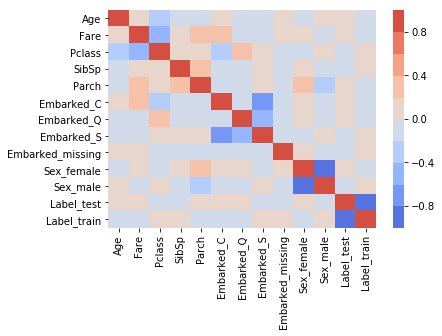

In [5]:
import seaborn as sns
corr = X_full.corr()
sns.heatmap(corr, cmap = sns.color_palette("coolwarm", 10))

In [6]:
# Split your data
X = X_full[X_full['Label_train'] == 1].copy()
X_test = X_full[X_full['Label_test'] == 1].copy()

# Drop your labels
X.drop('Label_train', axis=1, inplace=True)
X.drop('Label_test', axis=1, inplace=True)
X_test.drop('Label_test', axis=1, inplace=True)
X_test.drop('Label_train', axis=1, inplace=True)
y = train.Survived

In [7]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.7, test_size=0.3,
                                                                random_state=0)

In [8]:
from numpy import sort
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import mean_absolute_error
from xgboost import XGBClassifier

# Initial model
model = XGBClassifier(random_state = 18)
model.fit(X_train, y_train)

y_pred = model.predict(X_valid)
predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(y_valid, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

# Fit model using each importance as a threshold
thresholds = sort(model.feature_importances_)
models = []
for thresh in thresholds:
    # Select features using threshold
    selection = SelectFromModel(model, threshold=thresh, prefit=True)
    select_X_train = selection.transform(X_train)
    # Train model
    selection_model = XGBClassifier()
    selection_model.fit(select_X_train, y_train)
    models.append([selection_model, selection])
    # Eval model
    select_X_valid = selection.transform(X_valid)
    select_y_pred = selection_model.predict(select_X_valid)
    predictions = [round(value) for value in select_y_pred]
    accuracy = accuracy_score(y_valid, predictions)
    print("Thresh=%.3f, n=%d, Accuracy: %.2f%%" % (thresh, select_X_train.shape[1], accuracy*100.0))
    print("MAE: ", mean_absolute_error(y_valid, predictions))


Accuracy: 83.58%
Thresh=0.000, n=11, Accuracy: 83.58%
MAE:  0.16417910447761194
Thresh=0.000, n=11, Accuracy: 83.58%
MAE:  0.16417910447761194
Thresh=0.027, n=9, Accuracy: 83.58%
MAE:  0.16417910447761194
Thresh=0.027, n=8, Accuracy: 85.07%
MAE:  0.14925373134328357
Thresh=0.030, n=7, Accuracy: 82.46%
MAE:  0.17537313432835822
Thresh=0.038, n=6, Accuracy: 82.84%
MAE:  0.17164179104477612
Thresh=0.043, n=5, Accuracy: 84.33%
MAE:  0.15671641791044777
Thresh=0.093, n=4, Accuracy: 79.85%
MAE:  0.20149253731343283
Thresh=0.113, n=3, Accuracy: 80.97%
MAE:  0.19029850746268656
Thresh=0.151, n=2, Accuracy: 78.73%
MAE:  0.2126865671641791
Thresh=0.479, n=1, Accuracy: 78.73%
MAE:  0.2126865671641791


In [9]:
final_model = models[3][0]
final_selection = models[3][1]
final_X_train = final_selection.transform(X_train)

final_X_test = final_selection.transform(X_test)
final_X_valid = final_selection.transform(X_valid)

final_y_pred = final_model.predict(final_X_valid)
final_predictions = [round(value) for value in final_y_pred]

# Print evaluation metrics
accuracy = accuracy_score(y_valid, final_predictions)
print("n=%d, Accuracy: %.2f%%" % (final_X_train.shape[1], accuracy*100.0))
print("MAE: ", mean_absolute_error(y_valid, final_predictions))

n=8, Accuracy: 85.07%
MAE:  0.14925373134328357


In [10]:
# from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV

# Set up GridSearchCV in order to determine the best parameters for a gradient boosting model
grid_param = {  
    'n_estimators': [12, 25, 50, 75],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.05, 0.1],
    'early_stopping_rounds': [3, 4, 5, 6]
    }

gd_sr = GridSearchCV(estimator = final_model, param_grid = grid_param, 
                     cv = 3, n_jobs = -1, verbose = 2)

gd_sr.fit(X_train, y_train)  
best_parameters = gd_sr.best_params_
print(best_parameters)

Fitting 3 folds for each of 144 candidates, totalling 432 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    4.9s


{'early_stopping_rounds': 3, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 75}


[Parallel(n_jobs=-1)]: Done 432 out of 432 | elapsed:   10.7s finished


In [11]:
selection = SelectFromModel(model, threshold=0.027, prefit=True)
select_X_train = selection.transform(X_train)
select_X_test = selection.transform(X_test)
select_X_valid = selection.transform(X_valid)
another_model = XGBClassifier(early_stopping_rounds=3, learning_rate=0.01, max_depth=5, n_estimators=75)
another_model.fit(select_X_train, y_train)

select_y_pred = another_model.predict(select_X_valid)
select_predictions = [round(value) for value in select_y_pred]

# Print evaluation metrics
accuracy = accuracy_score(y_valid, select_predictions)
print("n=%d, Accuracy: %.2f%%" % (select_X_train.shape[1], accuracy*100.0))
print("MAE: ", mean_absolute_error(y_valid, select_predictions))

n=7, Accuracy: 81.72%
MAE:  0.1828358208955224


In [12]:
# Form confusion matrix
from sklearn.metrics import confusion_matrix
confusion_matrix(y_valid, final_y_pred)

array([[153,  15],
       [ 25,  75]])

In [13]:
final_preds = another_model.predict(select_X_test)

# Save test predictions to file
output = pd.DataFrame({'PassengerId':test.PassengerId,'Survived': final_preds})
print(output.head(15))
output.to_csv('submission.csv', index=False)

    PassengerId  Survived
0           892         0
1           893         0
2           894         0
3           895         0
4           896         1
5           897         0
6           898         1
7           899         0
8           900         1
9           901         0
10          902         0
11          903         0
12          904         1
13          905         0
14          906         1
